# Import python library



In [ ]:
import os, shutil
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io, signal
from scipy.fftpack import fft, fftshift

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

print("Installed tensorflow version: ", tf.__version__)

Installed tensorflow version:  2.0.0


# GPU setting

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # GPU unit setting
tf.keras.backend.floatx()

'float32'

# Parameters Setting for training

In [ ]:
### data parameters
winT = 18000 # one priod


### RMSprop optimizer parameters
lr_begin = 1e-3
RHO = 0.8

### Training parameters 
MAX_EPOCHS = 80
BATCH_SIZE = 128
EPOCH_1 = math.ceil(MAX_EPOCHS/2)
EPOCH_2 = math.ceil(MAX_EPOCHS*3/4)

# Load measured datasets

In [ ]:
print("[Info.] where am I?")
%pwd

[Info.] where am I?


'/home/ai/2021work/DeepLearning/ETRI/choi/arc-project/ver0.3'

In [ ]:
# Define signal plot function
def show_signal_subplot(n_show, data, label, YRNG_MIN=-1, YRNG_MAX=1):
    plt.figure(2, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.5)
    for i in range(n_show):
        plt.subplot(5, 10, i + 1)
        plt.plot(data[i], color='cornflowerblue')
        plt.text(int(data.shape[1]/2), 0, "%d" % label[i], fontsize=12, color='r')
        plt.xlim(0, data.shape[1])
        plt.ylim(YRNG_MIN, YRNG_MAX)
        
def data_shuffle(data):
    s = np.arange(data.shape[0])
    np.random.shuffle(s)
    
    return data[s]
    
    

def gen_one_period_data(file_path, winT):
    
    ##### load raw data
    data_raw = pd.read_excel(file_path, index_col=None, header=None, sheet_name='Sheet1')
    data = data_raw.to_numpy() # numpy array
    
    ##### Data Normalization
    data_n = np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]):
        data_n[:,i] = data[:,i]/max(abs(data[:,i]))  
    
    ##### expand one-period dataset
    dT = round(winT / 10)
    Num = round((data_n.shape[0] - winT)/dT)
    
    data_tot = np.zeros((winT,Num*data_n.shape[1]))
    index = 0
    for i in range(data_n.shape[1]):
        for j in range(Num):
            index = Num*i+j
            data_tot[:,index] = data_n[j*dT:winT+j*dT,i]
            
    print("[Info.] Total re-arranged one-period data shape: ", data_tot.shape)
    
    return data_tot

def merge_one_period_data(winT, *file_paths):
    
    subArrays = []
    for file_path in file_paths:
        data = gen_one_period_data(file_path, winT)
        subArrays.append(data)
                
    allArrays = np.concatenate(subArrays, axis=1)
    
    print("[Info.] ==========> Total merged one-period data shape: ", allArrays.shape, "\n")
        
    return allArrays

### 1. Fan dataset

In [ ]:
base_dir1 = "../dataset/20210927"
base_dir2 = "../dataset/20211122"
base_dir3 = "../dataset/20211224"

### Fan arc raw dataset
file_path1 = os.path.join(base_dir1, "Fan/arc/Fan_1_arc_humid_44(c61)_data.xlsx")
file_path2 = os.path.join(base_dir1, "Fan/arc/Fan_2_arc_humid_45_data.xlsx")
file_path3 = os.path.join(base_dir2, "Fan/arc/Fan_1_arc_humid_34(c14)_c2_data.xlsx")
file_path4 = os.path.join(base_dir2, "Fan/arc/Fan_2_arc_humid_34(c23)_c15_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4]
fan_arc = merge_one_period_data(winT, *file_paths)

##### Fan normal raw dataset
file_path1 = os.path.join(base_dir1, "Fan/normal/Fan_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir1, "Fan/normal/Fan_2_normal_humid_50_data.xlsx")
file_paths = [file_path1, file_path2]
fan_normal = merge_one_period_data(winT, *file_paths)

[Info.] Total re-arranged one-period data shape:  (18000, 1480)
[Info.] Total re-arranged one-period data shape:  (18000, 1560)
[Info.] Total re-arranged one-period data shape:  (18000, 80)
[Info.] Total re-arranged one-period data shape:  (18000, 600)
[Info.] ==========> Total merged one-period data shape:  (18000, 3720) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] ==========> Total merged one-period data shape:  (18000, 4000) 



In [ ]:
fan_arc_1 = data_shuffle(fan_arc.T)
fan_arc_2 = fan_arc_1.T[:,:]

fan_normal_1 = data_shuffle(fan_normal.T)
fan_normal_2 = fan_normal_1.T[:,:]

## 2. Fluor dataset

In [ ]:
### Fluor arc raw dataset
file_path1 = os.path.join(base_dir1, "Fluor/arc/Fluor_1_arc_humid_40(c79)_data.xlsx")
file_path2 = os.path.join(base_dir1, "Fluor/arc/Fluor_1_arc_humid_50(weird)_data.xlsx")
file_path3 = os.path.join(base_dir1, "Fluor/arc/Fluor_2_arc_humid_40(c65)_data.xlsx")
file_path4 = os.path.join(base_dir3, "Fluor/arc/Fluor_2_arc_humid_23(c51)_data(c45).xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4]
fluor_arc = merge_one_period_data(winT, *file_paths)

##### Fluor normal raw dataset
file_path1 = os.path.join(base_dir1, "Fluor/normal/Fluor_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir2, "Fluor/normal/Fluor_2_normal_humid_34_data.xlsx")
file_path3 = os.path.join(base_dir3, "Fluor/normal/Fluor_2_normal(c37)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3]
fluor_normal = merge_one_period_data(winT, *file_paths)

[Info.] Total re-arranged one-period data shape:  (18000, 3160)
[Info.] Total re-arranged one-period data shape:  (18000, 360)
[Info.] Total re-arranged one-period data shape:  (18000, 2600)
[Info.] Total re-arranged one-period data shape:  (18000, 1800)
[Info.] ==========> Total merged one-period data shape:  (18000, 7920) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 1480)
[Info.] ==========> Total merged one-period data shape:  (18000, 5480) 



In [ ]:
fluor_arc_1 = data_shuffle(fluor_arc.T)
fluor_arc_2 = fluor_arc_1.T[:,:5000]

fluor_normal_1 = data_shuffle(fluor_normal.T)
fluor_normal_2 = fluor_normal_1.T[:,:5000]

## 3. Heat dataset

In [ ]:
### Heat arc raw dataset
file_path1 = os.path.join(base_dir1, "Heat/arc/Heat_1_arc_humid_40(c56)_data.xlsx")
file_path2 = os.path.join(base_dir1, "Heat/arc/Heat_1_arc_humid_50_data.xlsx")
file_path3 = os.path.join(base_dir1, "Heat/arc/Heat_2_arc_humid_40_data.xlsx")
file_path4 = os.path.join(base_dir2, "Heat/arc/Heater_2_arc_humid_34(c27)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4]
heat_arc = merge_one_period_data(winT, *file_paths)

##### Heat normal raw dataset
file_path1 = os.path.join(base_dir1, "Heat/normal/Heat_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir1, "Heat/normal/Heat_2_normal_humid_40_data.xlsx")
file_paths = [file_path1, file_path2]
heat_normal = merge_one_period_data(winT, *file_paths)

[Info.] Total re-arranged one-period data shape:  (18000, 2240)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 1080)
[Info.] ==========> Total merged one-period data shape:  (18000, 7320) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] ==========> Total merged one-period data shape:  (18000, 4000) 



In [ ]:
heat_arc_1 = data_shuffle(heat_arc.T)
heat_arc_2 = heat_arc_1.T[:,:5000]

heat_normal_1 = data_shuffle(heat_normal.T)
heat_normal_2 = heat_normal_1.T[:,:4000]

## 4. incan dataset

In [ ]:
### Heat arc raw dataset
file_path1 = os.path.join(base_dir1, "incan/arc/incan_1_arc_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir1, "incan/arc/incan_2_arc_44_data.xlsx")
file_path3 = os.path.join(base_dir1, "incan/arc/Incan_2_arc_humid_40(c60)_data.xlsx")
file_path4 = os.path.join(base_dir1, "incan/arc/Incan_2_arc_humid_40(c61-c120)_data.xlsx")
file_path5 = os.path.join(base_dir1, "incan/arc/Incan_2_arc_humid_40(c121-c161)_data.xlsx")
file_path6 = os.path.join(base_dir1, "incan/arc/Incan_2_arc_humid_95(c60)_data.xlsx")
file_path7 = os.path.join(base_dir1, "incan/arc/Incan_2_arc_humid_95(c61-c82)_data.xlsx")
file_path8 = os.path.join(base_dir1, "incan/arc/Incan_2_arc_humid_room(after humid95)(c53)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4, file_path5, file_path6,
             file_path7, file_path8]
incan_arc = merge_one_period_data(winT, *file_paths)

##### Heat normal raw dataset
file_path1 = os.path.join(base_dir1, "incan/normal/incan_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir1, "incan/normal/incan_2_normal_humid_room_data.xlsx")
file_paths = [file_path1, file_path2]
incan_normal = merge_one_period_data(winT, *file_paths)

[Info.] Total re-arranged one-period data shape:  (18000, 1880)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2400)
[Info.] Total re-arranged one-period data shape:  (18000, 2400)
[Info.] Total re-arranged one-period data shape:  (18000, 1640)
[Info.] Total re-arranged one-period data shape:  (18000, 2400)
[Info.] Total re-arranged one-period data shape:  (18000, 880)
[Info.] Total re-arranged one-period data shape:  (18000, 2120)
[Info.] ==========> Total merged one-period data shape:  (18000, 15720) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] ==========> Total merged one-period data shape:  (18000, 4000) 



In [ ]:
incan_arc_1 = data_shuffle(incan_arc.T)
incan_arc_2 = incan_arc_1.T[:,:5000]

incan_normal_1 = data_shuffle(incan_normal.T)
incan_normal_2 = incan_normal_1.T[:,:4000]

# LED dataset

In [ ]:
### LED arc raw dataset
file_path1 = os.path.join(base_dir3, "Led/arc/led_1_arc_humid_23_c(30)_data(c29).xlsx")
file_path2 = os.path.join(base_dir3, "Led/arc/LED_1_arc(c19)_data.xlsx")
file_path3 = os.path.join(base_dir3, "Led/arc/LED_2_arc(c34)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3]
led_arc = merge_one_period_data(winT, *file_paths)

##### LED normal raw dataset
file_path1 = os.path.join(base_dir3, "Led/normal/led_1_normal_c(36)_data.xlsx")
file_path2 = os.path.join(base_dir3, "Led/normal/led_1_normal_humid_room_data.xlsx")
file_path3 = os.path.join(base_dir3, "Led/normal/led_2_normal_c(32)_data.xlsx")
file_path4 = os.path.join(base_dir3, "Led/normal/LED_2_normal(c40)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4]
led_normal = merge_one_period_data(winT, *file_paths)

[Info.] Total re-arranged one-period data shape:  (18000, 1160)
[Info.] Total re-arranged one-period data shape:  (18000, 760)
[Info.] Total re-arranged one-period data shape:  (18000, 1360)
[Info.] ==========> Total merged one-period data shape:  (18000, 3280) 

[Info.] Total re-arranged one-period data shape:  (18000, 1440)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 1280)
[Info.] Total re-arranged one-period data shape:  (18000, 1600)
[Info.] ==========> Total merged one-period data shape:  (18000, 6320) 



In [ ]:
led_arc_1 = data_shuffle(led_arc.T)
led_arc_2 = led_arc_1.T[:,:]

led_normal_1 = data_shuffle(led_normal.T)
led_normal_2 = led_normal_1.T[:,:5000]

# Data Labeling

In [ ]:
##### Fan Labeling
norm_fan_label = np.zeros(fan_normal_2.shape[1]) # label 0
arc_fan_label = np.ones(fan_arc_2.shape[1])  # label 1

##### Fluor Labeling
norm_fluor_label = 2*np.ones(fluor_normal_2.shape[1]) # label 2
arc_fluor_label = 3*np.ones(fluor_arc_2.shape[1])  # label 3

##### Heat Labeling
norm_heat_label = 4*np.ones(heat_normal_2.shape[1]) # label 4
arc_heat_label = 5*np.ones(heat_arc_2.shape[1])  # label 5

##### Incan Labeling
norm_incan_label = 6*np.ones(incan_normal_2.shape[1]) # label 6
arc_incan_label = 7*np.ones(incan_arc_2.shape[1])  # label 7

##### LED Labeling
norm_led_label = 8*np.ones(led_normal_2.shape[1]) # label 8
arc_led_label = 9*np.ones(led_arc_2.shape[1])  # label 9

# Data Shuffling

In [ ]:
##### Prepare full datasets for training
Train_raw = np.concatenate((fan_normal_2.T, fan_arc_2.T, fluor_normal_2.T, fluor_arc_2.T,
                           heat_normal_2.T, heat_arc_2.T, incan_normal_2.T, incan_arc_2.T, 
                           led_normal_2.T, led_arc_2.T), axis=0)
Train_label = np.concatenate((norm_fan_label, arc_fan_label, norm_fluor_label, arc_fluor_label,
                             norm_heat_label, arc_heat_label, norm_incan_label, arc_incan_label,
                             norm_led_label, arc_led_label))
print('[Info.] Total dataset shape: ', Train_raw.shape)

[Info.] Total dataset shape:  (44000, 18000)


In [ ]:
# s라는 배열에 data의 인덱스를 넣고 섞은 뒤 data와 data_label 배열에 대입.(train)
s = np.arange(Train_raw.shape[0])
np.random.shuffle(s)

data_tr = Train_raw[s]
data_tr_label = Train_label[s]
print("===> Display label numbers after data shuffling:", "\n", data_tr_label[0:100])

===> Display label numbers after data shuffling: 
 [3. 3. 2. 3. 2. 0. 3. 1. 1. 9. 8. 1. 5. 5. 1. 7. 5. 2. 3. 5. 3. 0. 9. 7.
 0. 4. 8. 9. 7. 2. 6. 8. 5. 7. 6. 2. 5. 3. 6. 4. 5. 1. 0. 8. 4. 8. 3. 6.
 5. 5. 6. 8. 5. 1. 7. 0. 3. 8. 7. 4. 5. 0. 4. 6. 7. 6. 9. 5. 5. 2. 3. 9.
 9. 0. 5. 2. 5. 8. 7. 0. 5. 2. 1. 4. 6. 0. 4. 4. 8. 0. 6. 5. 3. 7. 9. 7.
 9. 6. 5. 4.]


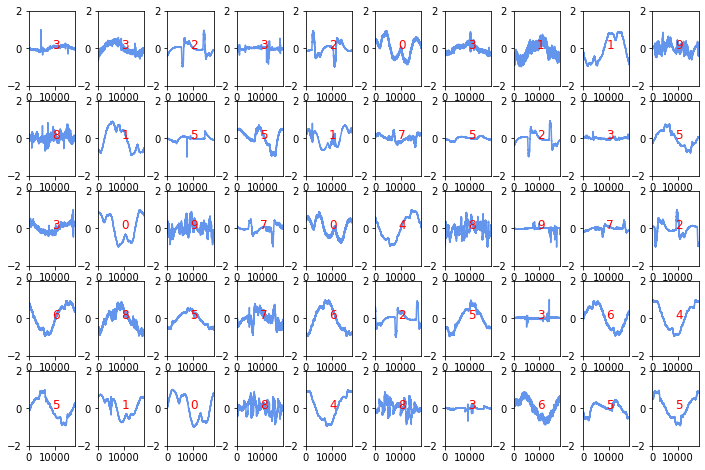

In [ ]:
show_signal_subplot(50, data_tr, data_tr_label, -2, 2)

# Construct Train and Testing dataset

In [ ]:
SPL_RATIO = 0.8 
index = round(data_tr.shape[0]*SPL_RATIO)

### train 데이터와 test 데이터로 분리
train_X, train_Y = data_tr[:index], data_tr_label[:index]
test_X, test_Y = data_tr[index:], data_tr_label[index:]
print('[Info.] Number of training dataset: ', len(train_X))
print('[Info.] Number of test dataset: ', len(test_X))

### Save trainind and test datasets and labels
dataset_dir = './TrTedata'
if os.path.exists(dataset_dir):  # 반복적인 실행을 위해 디렉토리를 삭제
    shutil.rmtree(dataset_dir)   
os.mkdir(dataset_dir)

# training
train_X_dir = os.path.join(dataset_dir, 'train_X.npy')
np.save(train_X_dir, train_X)

train_Y_dir = os.path.join(dataset_dir, 'train_Y.npy')
np.save(train_Y_dir, train_Y)

# test
test_X_dir = os.path.join(dataset_dir, 'test_X.npy')
np.save(test_X_dir, test_X)

test_Y_dir = os.path.join(dataset_dir, 'test_Y.npy')
np.save(test_Y_dir, test_Y)

[Info.] Number of training dataset:  35200
[Info.] Number of test dataset:  8800


In [ ]:
### Training and test datasets
x_train = np.reshape(train_X, (len(train_X),train_X.shape[1],1))
x_test = np.reshape(test_X, (len(test_X),train_X.shape[1],1))

### Training and test labeling
y_train = np.asarray(train_Y).astype('float32')
y_test = np.asarray(test_Y).astype('float32')

print('[Info.] x_train numpy shape: ', x_train.shape)
print('[Info.] x_test numpy shape: ', x_test.shape)

[Info.] x_train numpy shape:  (35200, 18000, 1)
[Info.] x_test numpy shape:  (8800, 18000, 1)


# 케라스 Callback 및 learning rate 설정

In [ ]:
# learning rate 구간별로 설정 0.1 ~ 0.001
def lr_schedule(epoch):
    lr = lr_begin
    if epoch > EPOCH_2: # # Second step-decay
        lr *= 1e-2
    elif epoch > EPOCH_1: # First step-decay
        lr *= 1e-1
    print('Learning rate : ', lr)
    
    return lr 

# callback 설정 - step-decay learning rate schedule
callback_list = [LearningRateScheduler(lr_schedule)]

# Arc Detection Deep-Learning Model
## - 1D CNN

In [ ]:
def create_arc_model(NUM_SAMPLES=x_train.shape[1]):
    
    network = models.Sequential()
    network.add(layers.Conv1D(128, 5, strides=2, kernel_regularizer=regularizers.l2(0.0001),
                              padding ='same',input_shape=(NUM_SAMPLES,1), activation='relu'))  # 1D 컨브넷 - (32,3) 유닛으로 된 밀집 층
    network.add(layers.BatchNormalization()) #훈련하는 동안 평균,분산 이 바뀌어도 데이터 정규화 - 깊은 네트워크 구성을 위함
    network.add(layers.MaxPooling1D()) # 특성 맵 가중치 줄이기 
    network.add(layers.Conv1D(256, 3, strides=2, kernel_regularizer=regularizers.l2(0.0001), 
                                padding='same',activation='elu')) # 1D 컨브넷 - (64,3) 유닛으로 된 밀집 층
    network.add(layers.BatchNormalization())
    network.add(layers.MaxPooling1D())
    network.add(layers.GlobalMaxPooling1D())
    network.add(layers.Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
    network.add(layers.BatchNormalization())
    network.add(layers.Dropout(0.3))
    #network.add(layers.Dense(64, activation='elu'))
    #network.add(layers.Dropout(0.3))
    network.add(layers.Dense(10, activation='softmax'))
    
    return network

model = create_arc_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9000, 128)         768       
_________________________________________________________________
batch_normalization (BatchNo (None, 9000, 128)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4500, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2250, 256)         98560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2250, 256)         1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1125, 256)         0         
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0

# Optimizer 설정

In [ ]:
#opt = optimizers.SGD(learning_rate=lr_schedule(0), momentum=0.9, nesterov=True)
#opt = optimizers.Adam(lr=lr_schedule(0), beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# rmsprop learning rate 및 rho 설정 
# rho : Discounting factor for the history/coming gradient
opt = optimizers.RMSprop(lr = lr_schedule(0), rho = RHO) 

Learning rate :  0.001


#  Model Compile

In [ ]:
model = create_arc_model()
model.compile(optimizer=opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training

In [ ]:
startTime = time.time()
history = model.fit(x_train, y_train, epochs=MAX_EPOCHS, verbose=1,
                    batch_size=BATCH_SIZE, callbacks=callback_list, 
                    validation_data=(x_test, y_test))
endTime = time.time()
Elapsed_time = endTime - startTime
print("/n")
print("========== [Info.] Training time:{0:.3f} min.".format(Elapsed_time/60))

Train on 35200 samples, validate on 8800 samples
Learning rate :  0.001
Epoch 1/80
35200/35200 [==============================] - 63s 2ms/sample - loss: 0.9330 - accuracy: 0.6797 - val_loss: 4.9044 - val_accuracy: 0.1258
Learning rate :  0.001
Epoch 2/80
35200/35200 [==============================] - 59s 2ms/sample - loss: 0.4191 - accuracy: 0.8647 - val_loss: 2.8805 - val_accuracy: 0.4939
Learning rate :  0.001
Epoch 3/80
35200/35200 [==============================] - 59s 2ms/sample - loss: 0.2649 - accuracy: 0.9324 - val_loss: 0.7827 - val_accuracy: 0.8023
Learning rate :  0.001
Epoch 4/80
35200/35200 [==============================] - 59s 2ms/sample - loss: 0.1875 - accuracy: 0.9612 - val_loss: 1.4367 - val_accuracy: 0.7495
Learning rate :  0.001
Epoch 5/80
35200/35200 [==============================] - 60s 2ms/sample - loss: 0.1541 - accuracy: 0.9699 - val_loss: 0.8527 - val_accuracy: 0.7526
Learning rate :  0.001
Epoch 6/80
35200/35200 [==============================] - 60s 2ms/sa

35200/35200 [==============================] - 60s 2ms/sample - loss: 0.0204 - accuracy: 0.9994 - val_loss: 0.0231 - val_accuracy: 0.9990
Learning rate :  0.0001
Epoch 49/80
35200/35200 [==============================] - 60s 2ms/sample - loss: 0.0194 - accuracy: 0.9995 - val_loss: 0.0235 - val_accuracy: 0.9987
Learning rate :  0.0001
Epoch 50/80
35200/35200 [==============================] - 60s 2ms/sample - loss: 0.0188 - accuracy: 0.9995 - val_loss: 0.0276 - val_accuracy: 0.9966
Learning rate :  0.0001
Epoch 51/80
35200/35200 [==============================] - 60s 2ms/sample - loss: 0.0179 - accuracy: 0.9996 - val_loss: 0.0202 - val_accuracy: 0.9993
Learning rate :  0.0001
Epoch 52/80
35200/35200 [==============================] - 60s 2ms/sample - loss: 0.0181 - accuracy: 0.9992 - val_loss: 0.0210 - val_accuracy: 0.9989
Learning rate :  0.0001
Epoch 53/80
35200/35200 [==============================] - 60s 2ms/sample - loss: 0.0174 - accuracy: 0.9993 - val_loss: 0.0193 - val_accuracy:

# Plot the learning curve

In [ ]:
# 부드러운 곡선 형태의 그래프 만들어주기 - exponential moving average(지수 이동 평균) 대체 
# Define smooth curve fitting function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor)) # 이동평균에 factor를 곱하고 현재 포인트에 (1- factor)를 곱해 합산
        else:
            smoothed_points.append(point)
            
    return smoothed_points

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

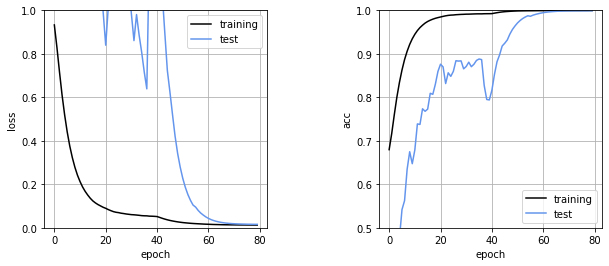

In [ ]:
##### Plot training and test loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
plt.plot(smooth_curve(history.history['loss']), label='training', color='black')
plt.plot(smooth_curve(history.history['val_loss']), label='test',
         color='cornflowerblue')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(smooth_curve(history.history['accuracy']), label='training', color='black')
plt.plot(smooth_curve(history.history['val_accuracy']),label='test', color='cornflowerblue')
plt.ylim(0.5, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# Evaluate the trained model accuracy using test dataset

In [ ]:
##### Obtain test result in terms of classification accuracy
scores = model.evaluate(x_test, y_test, verbose=0) #전체 특징 - 시험데이터 결과 
print("[INFO] test loss: {:.4f}".format(scores[0]))
print("[INFO] test accuracy: {:.4f}".format(scores[1]))

[INFO] test loss: 0.0157
[INFO] test accuracy: 0.9990


# Model Save

In [ ]:
##### Save trained model
model_dir = "./save_model"
if os.path.exists(model_dir):
    pass
else:
    os.mkdir(model_dir)
    
model_path = os.path.join(model_dir, 'cnn1D_arc_model_1.h5')    
model.save(model_path)